In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np 
import pandas as pd 
import torch
import torch.nn as nn
import torch.optim as optim
import string
import re
import seaborn as sns
import torchvision
import os
from torch.utils.data import DataLoader
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
import pickle
import nltk

from PIL import Image
from collections import Counter

nltk.download('punkt')

import torchvision.models as models
import torch.utils.data as data


from torch.nn.utils.rnn import pack_padded_sequence

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:


size = [256, 256] # 조정될 이미지 크기


image_path = "/content/drive/MyDrive/2022-2 Deep" # 캡션(caption)을 생성할 입력 이미지
encoder_path = "/content/drive/MyDrive/2022-2 Deep/nic_encoder_ResNet101.ckpt" # path for trained encoder
decoder_path = "/content/drive/MyDrive/2022-2 Deep/nic_decoder_ResNet101.ckpt" # path for trained decoder
vocab_path = "/content/drive/MyDrive/2022-2 Deep/vocab.pkl" # path for vocabulary wrapper
word_threshold = 4 # 최소 단어 등장 횟수


In [ ]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        # 사전 학습된(pre-trained) ResNet-101을 불러와 FC 레이어를 교체
        super(EncoderCNN, self).__init__()
        resnet = models.resnet101(pretrained=True)
        modules = list(resnet.children())[:-1] # 마지막 FC 레이어를 제거
        self.resnet = nn.Sequential(*modules)
        self.linear = nn.Linear(resnet.fc.in_features, embed_size) # 결과(output) 차원을 임베딩 차원으로 변경
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)

    def forward(self, images):
        # 입력 이미지에서 특징 벡터(feature vectors)
        with torch.no_grad(): # 네트워크의 앞 부분은 변경되지 않도록 하기
            features = self.resnet(images)
        features = features.reshape(features.size(0), -1)
        features = self.bn(self.linear(features))
        return features


class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=20):
        # 하이퍼 파라미터(hyper-parameters) 설정 및 레이어 생성
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size) #세로는 vocab size만큼
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seg_length = max_seq_length

    def forward(self, features, captions, lengths):
        # 이미지 특징 벡터(feature vectors)로부터 캡션(caption) 생성
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1) # 이미지 특징과 임베딩 연결
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True) # 패딩을 넣어 차원 맞추기
        hiddens, _ = self.lstm(packed) # 다음 hidden state 구하기
        outputs = self.linear(hiddens[0])
        return outputs

    def sample(self, features, states=None):
        # 간단히 그리디(greedy) 탐색으로 캡션(caption) 생성하기
        sampled_indexes = []
        inputs = features.unsqueeze(1)
        for i in range(self.max_seg_length):
            hiddens, states = self.lstm(inputs, states) # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1)) # outputs: (batch_size, vocab_size)
            _, predicted = outputs.max(1) # predicted: (batch_size)
            sampled_indexes.append(predicted)
            inputs = self.embed(predicted) # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1) # inputs: (batch_size, 1, embed_size)
        sampled_indexes = torch.stack(sampled_indexes, 1) # sampled_indexes: (batch_size, max_seq_length)
        return sampled_indexes

In [ ]:
def load_image(image_path, transform=None):
    image = Image.open(image_path).convert('RGB')
    image = image.resize([224, 224], Image.LANCZOS)

    if transform is not None:
        image = transform(image).unsqueeze(0)
    
    return image


# Model parameters (should be same as paramters in train.py)
embed_size = 256 # dimension of word embedding vectors
hidden_size = 512 # dimension of lstm hidden states
num_layers = 1 # number of layers in lstm

In [ ]:
class Vocabulary(object):

    
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1
    #존재하지 않는 단어 처리
    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

In [ ]:
# Flickr8k 데이터셋 클래스 정의
# 이미지와 문장들을 pair로 묶어서
class Flickr8kDataset(data.Dataset):
    def __init__(self, root, captions, vocab, transform=None):
        self.root = root # 이미지가 존재하는 경로
        with open(captions, "r") as f:
            lines = f.readlines()
            self.captions = [] # 캡션(caption) 정보를 담을 리스트
            for line in lines: # 첫 번째 줄부터 바로 캡션 정보 존재
                index = line.find(",") # 캡션(caption) 문자열의 시작점 찾기
                path = line[:index] # 이미지 파일 이름
                caption = line[index + 1:] # 캡션(caption) 문자열 기록
                self.captions.append((path, caption))
        self.vocab = vocab
        self.transform = transform

    # 이미지와 캡션(caption)을 하나씩 꺼내는 메서드
    def __getitem__(self, index):
        vocab = self.vocab
        path = self.captions[index][0]
        caption = self.captions[index][1]
        #이미지는 RGB로
        image = Image.open(os.path.join(self.root, path)).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)

        # 캡션(caption) 문자열을 토큰 형태로 바꾸기
        tokens = nltk.tokenize.word_tokenize(str(caption).lower())
        caption = []
        caption.append(vocab('<start>'))
        caption.extend([vocab(token) for token in tokens])
        caption.append(vocab('<end>'))
        target = torch.Tensor(caption)
        return image, target

    def __len__(self):
        return len(self.captions)

In [ ]:
from torchvision import transforms
import pickle
# 이미지 전처리(image preprocessing)
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

# Load vocabulary wrapper
with open(vocab_path, 'rb') as f:
    vocab = pickle.load(f)

#choose device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Build models
encoder = EncoderCNN(embed_size).eval() # eval mode (batchnorm uses moving mean/variance)
decoder = DecoderRNN(embed_size, hidden_size, len(vocab), num_layers)
encoder = encoder.to(device)
decoder = decoder.to(device)

# Load the trained model parameters
encoder.load_state_dict(torch.load(encoder_path))
decoder.load_state_dict(torch.load(decoder_path))

# Prepare an image
temp = []
for i in range(1,51):
    image = load_image(image_path+f"/image{i}.jpeg", transform)
    image_tensor = image.to(device)

# Generate an caption from the image
    feature = encoder(image_tensor)
    sampled_ids = decoder.sample(feature)
    sampled_ids = sampled_ids[0].cpu().numpy() # (1, max_seq_length) -> (max_seq_length)

    # Convert word_ids to words
    sampled_caption = []
    for word_id in sampled_ids: # 하나씩 단어 인덱스를 확인하며
        word = vocab.idx2word[word_id] # 단어 문자열로 바꾸어 삽입
        sampled_caption.append(word)
        if word == '':
            break
    sentence = ' '.join(sampled_caption)
    temp.append(sentence)

print(temp)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

['<start> a group of people are standing on a rocky mountain . <end> <end> <end> <end> <end> <end> <end> <end>', '<start> a man in a red jacket is standing on a rocky mountain . <end> <end> <end> <end> <end> <end>', '<start> a man in a wetsuit is surfing in the ocean . <end> <end> <end> <end> <end> . <end> <end>', '<start> a woman and a child are playing in the water . <end> <end> <end> a beach . <end> <end>', '<start> a girl in a bikini is jumping into the water . <end> <end> <end> . <end> <end> <end> .', '<start> a black and white dog is running through the water . <end> <end> <end> . <end> <end> <end> .', '<start> two men are standing on a beach . <end> <end> a beach . <end> <end> <end> <end> to the', '<start> two girls are playing in the sand . <end> <end> <end> . <end> <end> <end> <end> . <end> <end>', '<start> a woman and a dog are playing in the water . <end> <end> <end> . <end> <end> <end> <end>', '<start> a boy in a swimming pool is being splashed by a pool . <end> <end> <end>

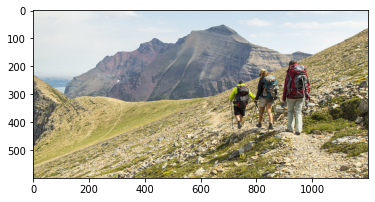

<start> a group of people are standing on a rocky mountain . <end> <end> <end> <end> <end> <end> <end> <end>


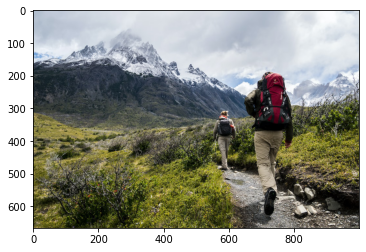

<start> a man in a red jacket is standing on a rocky mountain . <end> <end> <end> <end> <end> <end>


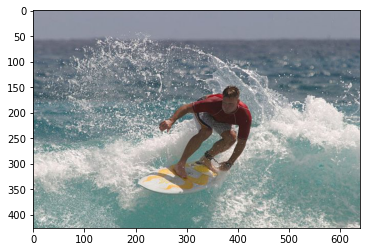

<start> a man in a wetsuit is surfing in the ocean . <end> <end> <end> <end> <end> . <end> <end>


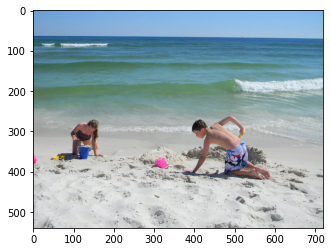

<start> a woman and a child are playing in the water . <end> <end> <end> a beach . <end> <end>


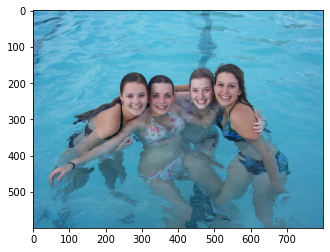

<start> a girl in a bikini is jumping into the water . <end> <end> <end> . <end> <end> <end> .


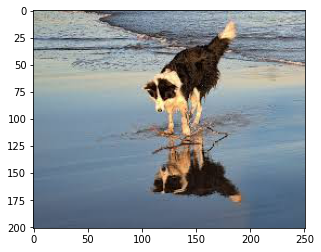

<start> a black and white dog is running through the water . <end> <end> <end> . <end> <end> <end> .


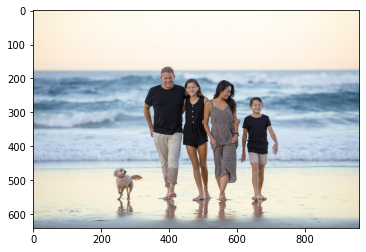

<start> two men are standing on a beach . <end> <end> a beach . <end> <end> <end> <end> to the


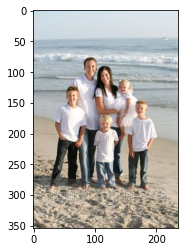

<start> two girls are playing in the sand . <end> <end> <end> . <end> <end> <end> <end> . <end> <end>


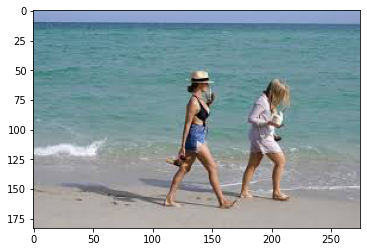

<start> a woman and a dog are playing in the water . <end> <end> <end> . <end> <end> <end> <end>


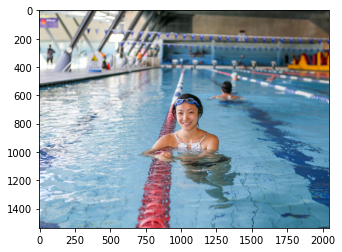

<start> a boy in a swimming pool is being splashed by a pool . <end> <end> <end> . <end> <end>


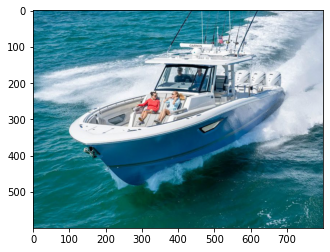

<start> a man is rowing a canoe on a lake . <end> <end> <end> <end> <end> <end> . <end> <end>


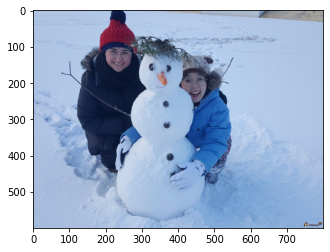

<start> a child in a red jacket is climbing a snow covered hill . <end> <end> <end> <end> <end> .


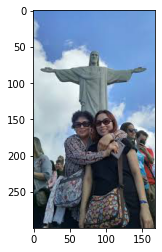

<start> a group of people are standing in front of a large building . <end> <end> <end> <end> <end> .


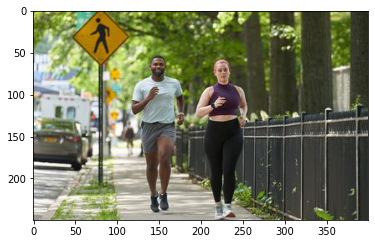

<start> a man in a white shirt and black pants is riding a bike . <end> <end> <end> <end> .


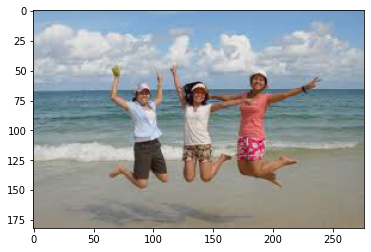

<start> two girls are playing in a pool . <end> <end> <end> . <end> <end> <end> <end> . <end> <end>


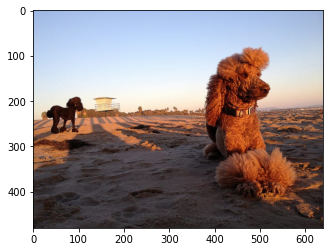

<start> a woman is standing on a beach with a dog . <end> <end> <end> . <end> <end> <end> <end>


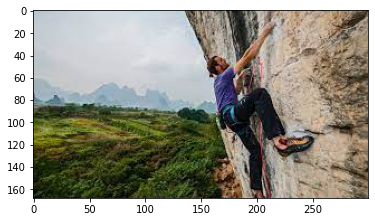

<start> a man is climbing a rock wall . <end> <end> <end> <end> <end> <end> <end> . <end> <end> <end>


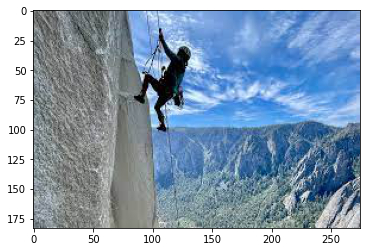

<start> a man is doing a trick on a surfboard . <end> <end> <end> <end> <end> <end> <end> <end> <end>


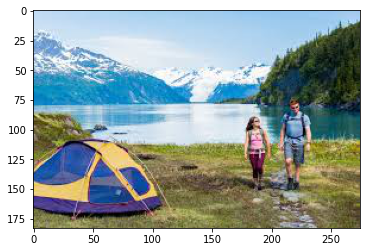

<start> a group of people are standing in a river . <end> <end> <end> . <end> <end> <end> <end> .


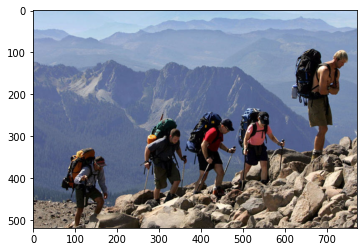

<start> a group of people are standing on a rocky shore . <end> <end> <end> <end> <end> <end> <end> <end>


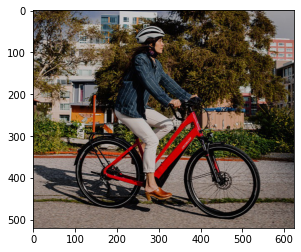

<start> a man in a red shirt and helmet is riding a bicycle . <end> <end> <end> <end> . <end>


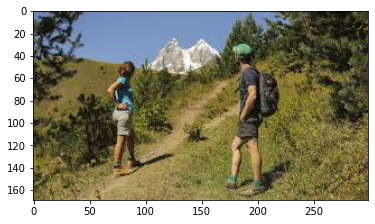

<start> a group of people are walking through a grassy field . <end> <end> <end> a hill . <end> <end>


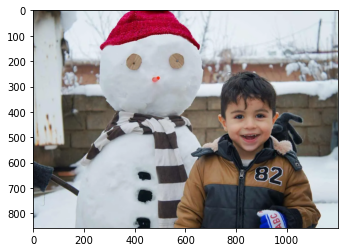

<start> a woman wearing a red hat and a white shirt is holding a drink . <end> <end> <end> .


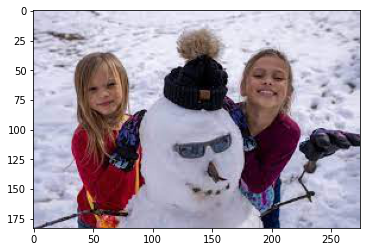

<start> a woman in a red coat is holding a large stick in the snow . <end> <end> <end> .


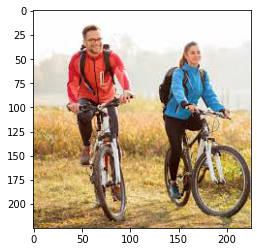

<start> a man in a red shirt and helmet riding a bike on a dirt road . <end> <end> <end>


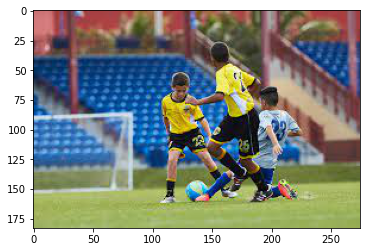

<start> a boy in a blue shirt is playing soccer . <end> <end> <end> to another dog . <end> <end>


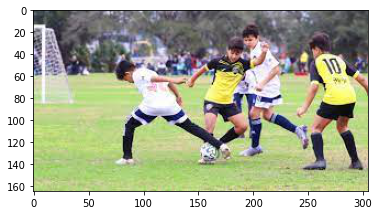

<start> a group of men playing soccer . <end> <end> <end> <end> . <end> <end> <end> <end> <end> <end> .


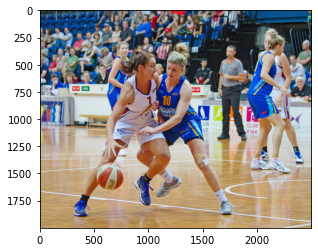

<start> a basketball player in a red uniform is playing basketball . <end> <end> <end> <end> . <end> <end> <end>


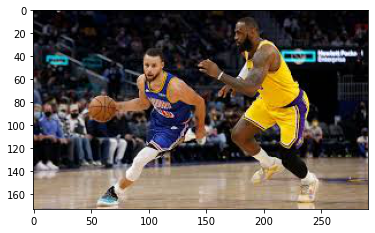

<start> a basketball player in a red uniform is being tackled by a player in a red uniform . <end>


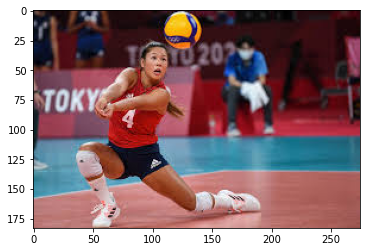

<start> a basketball player in a red uniform is playing with a basketball . <end> <end> <end> <end> . <end>


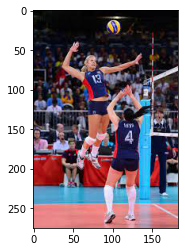

<start> a basketball player is being tackled by a player in a white uniform . <end> <end> <end> . <end>


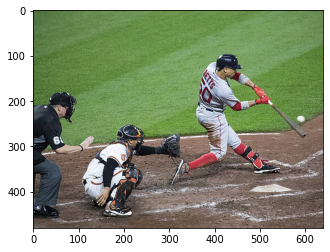

<start> a group of men playing basketball . <end> <end> <end> <end> . <end> <end> <end> <end> <end> . <end>


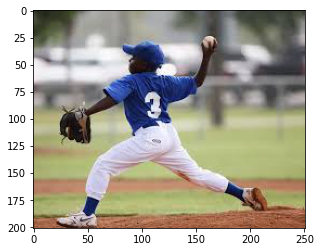

<start> a boy in a blue shirt is playing tennis . <end> <end> <end> to catch a tennis ball .


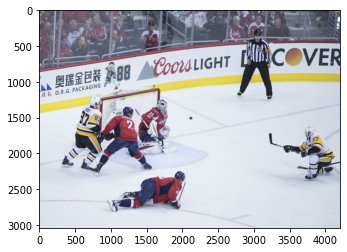

<start> a group of people are in a race . <end> <end> <end> <end> <end> <end> <end> <end> <end> <end>


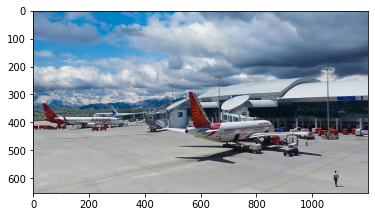

<start> a snowboarder is doing a trick on a ramp . <end> <end> <end> <end> . <end> <end> <end> <end>


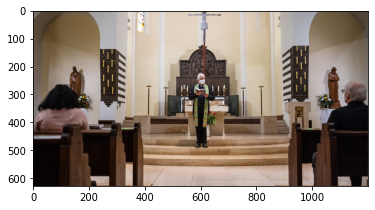

<start> a man stands on a bench reading a book . <end> <end> <end> . <end> <end> <end> <end> .


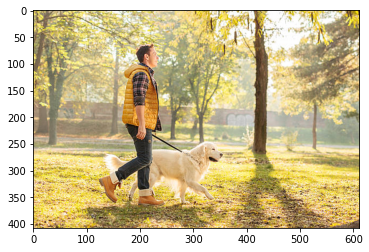

<start> a man and a dog are playing in the grass . <end> <end> <end> <end> <end> <end> <end> <end>


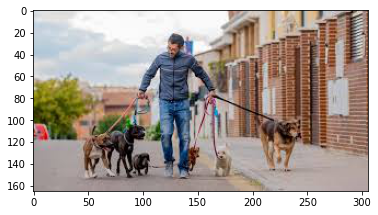

<start> a dog is jumping over a hurdle . <end> <end> <end> a man in a white shirt . <end>


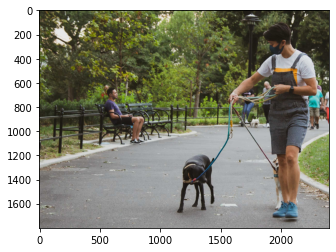

<start> a man and a woman are sitting on a bench . <end> <end> <end> a dog . <end> <end>


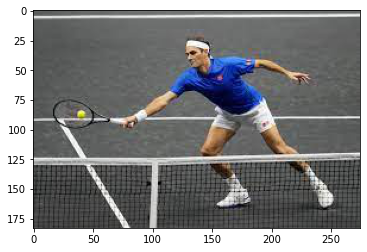

<start> a man in a blue shirt is playing tennis . <end> <end> <end> to catch a tennis ball .


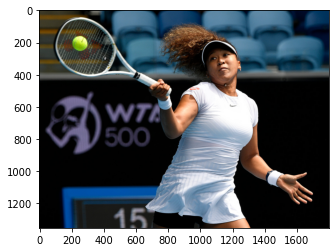

<start> a woman in a white shirt and black skirt is holding a tennis racket . <end> <end> <end> .


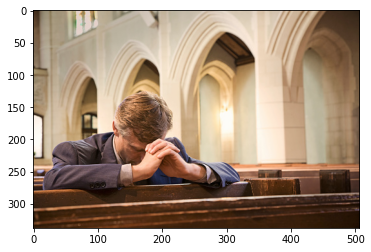

<start> a boy is sitting on a <unk> in a chair . <end> <end> <end> . <end> <end> <end> <end>


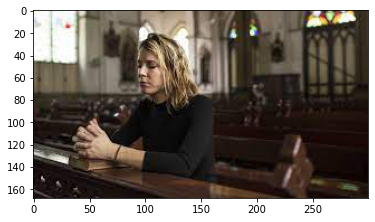

<start> a man is sitting on a bench with a woman in a white shirt . <end> <end> <end> .


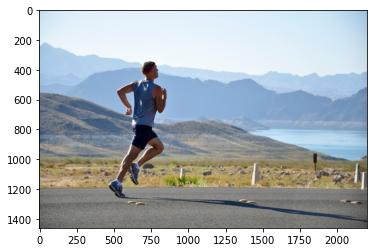

<start> a man is doing a trick on a bike . <end> <end> <end> <end> <end> <end> <end> <end> <end>


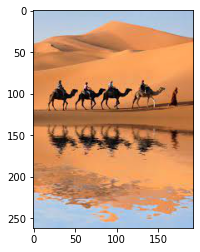

<start> a group of people are standing on a beach . <end> <end> <end> a beach . <end> <end> <end>


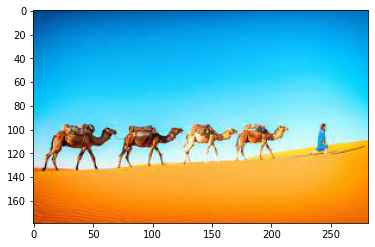

<start> a group of people are standing on a beach . <end> <end> <end> <end> <end> <end> <end> . <end>


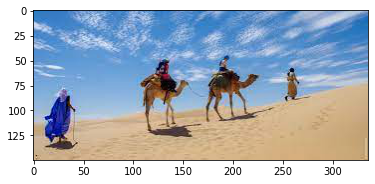

<start> a group of people are riding a sled down a snowy hill . <end> <end> <end> <end> <end> <end>


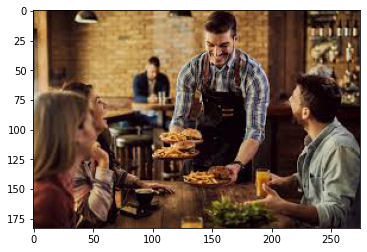

<start> a man and woman are sitting on a bench . <end> <end> <end> . <end> <end> <end> <end> to


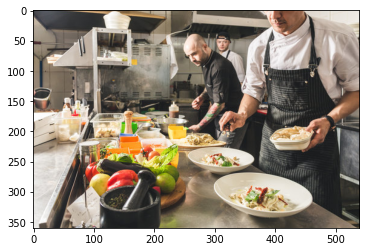

<start> a man in a white shirt and black hat is sitting on a bench . <end> <end> <end> <end>


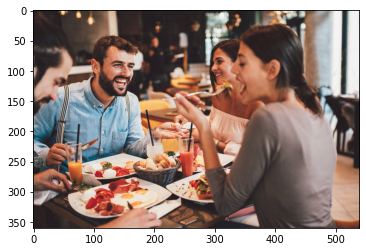

<start> a man in a white shirt and black pants is holding a drink . <end> <end> <end> . <end>


In [ ]:
import matplotlib.pyplot as plt
# 이미지 및 생성된 캡션(caption) 문장 출력

for i in range(1,51):
    image = Image.open(image_path+f"/image{i}.jpeg")
    plt.imshow(np.asarray(image))
    plt.show()
    print(temp[i-1])

# Sentences for clustering

In [ ]:
sentenceL=pd.DataFrame(temp)
sentenceL.rename(columns = {0:"sentence"}, inplace=True)
sentenceL['sentence']=sentenceL['sentence'].str.replace(r"<start>","")
sentenceL['sentence']=sentenceL['sentence'].str.replace(r"<end>","")
sentenceL['sentence']=sentenceL['sentence'].str.replace(r"<unk>","")

In [ ]:
sentenceL
sentenceL.to_csv("hyunji.csv")

# BLEU score

In [ ]:
def collate_fn(data):

    # Caption 길이로 각 데이터를 내림차순 정렬
    data.sort(key=lambda x: len(x[1]), reverse=True)
    images, captions = zip(*data)

    # 리스트 형태의 이미지들을 텐서 하나로 합치기(데이터 개수, 3, 256, 256)
    images = torch.stack(images, 0)

    # 리스트 형태의 캡션들을 텐서 하나로 합치기(데이터 개수, 문장 내 최대 토큰 개수)
    lengths = [len(caption) for caption in captions]
    targets = torch.zeros(len(captions), max(lengths)).long()
    # 하나씩 캡션을 확인하며 앞 부분의 내용을 패딩이 아닌 원래 토큰으로 채우기
    for i, cap in enumerate(captions):
        end = lengths[i]
        targets[i, :end] = cap[:end]
    return images, targets, lengths

def collate_fn_test(data):
    # 기존 순서를 그대로 사용 (차례대로 5개씩 같은 이미지를 표현)
    images, captions = zip(*data)

    # 리스트 형태의 이미지들을 텐서 하나로 합치기(데이터 개수, 3, 256, 256)
    images = torch.stack(images, 0)

    # 리스트 형태의 캡션들을 텐서 하나로 합치기(데이터 개수, 문장 내 최대 토큰 개수)
    lengths = [len(caption) for caption in captions]
    targets = torch.zeros(len(captions), max(lengths)).long()
    # 하나씩 캡션을 확인하며 앞 부분의 내용을 패딩이 아닌 원래 토큰으로 채우기
    for i, cap in enumerate(captions):
        end = lengths[i]
        targets[i, :end] = cap[:end]
    return images, targets, lengths

# 커스텀 Flickr8k 데이터셋을 위한 DataLoader 객체 반환
def get_loader(root, captions, vocab, transform, batch_size, shuffle, num_workers, testing):
    flickr8k = Flickr8kDataset(root=root, captions=captions, vocab=vocab, transform=transform)
    if not testing:
        data_loader = torch.utils.data.DataLoader(dataset=flickr8k, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, collate_fn=collate_fn)
    else:
        data_loader = torch.utils.data.DataLoader(dataset=flickr8k, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, collate_fn=collate_fn_test)
    return data_loader

In [ ]:
import torch
from torch.nn.utils.rnn import pack_padded_sequence
from torchvision import transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

test_image_dir = "/content/drive/MyDrive/2022-2 Deep/images_new" # 크기가 조정된 이미지가 담길 경로 (테스트)
test_caption_path = "/content/drive/MyDrive/2022-2 Deep/captions_new.txt" 

model_path = "models/" # 학습된 모델이 저장될 경로
crop_size = 224 # 랜덤하게 잘라낼 이미지 크기

# 모델 디렉토리 만들기
if not os.path.exists(model_path):
    os.makedirs(model_path)

# Vocabulary 파일 불러오기
with open(vocab_path, 'rb') as f:
    vocab = pickle.load(f)

# 사전 학습된(pre-trained) ResNet에 적용된 전처리 및 정규화 파라미터를 그대로 사용합니다.

test_transform = transforms.Compose([ 
    transforms.Resize(crop_size), 
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

batch_size = 128
num_workers = 2

# 데이터 로더(data loader) 선언
test_data_loader = get_loader(test_image_dir, test_caption_path, vocab, test_transform, batch_size, shuffle=False, num_workers=num_workers, testing=True)


In [ ]:
predictions = []
answers = []
answers_per_image = []

total_step = len(test_data_loader)
cnt = 0
log_step = 20 

with torch.no_grad():
    for i, (images, captions, lengths) in enumerate(test_data_loader):
        images = images.to(device)
        captions = captions.to(device)

        # 순전파(forward) 진행
        features = encoder(images)
        sampled_ids_list = decoder.sample(features)

        for index in range(len(images)):
            sampled_ids = sampled_ids_list[index].cpu().numpy()

            # 정답 문장(answer sentences)
            answer = []
            for word_id in captions[index]: # 하나씩 단어 인덱스를 확인하며
                word = vocab.idx2word[word_id.item()] # 단어 문자열로 바꾸어 삽입
                answer.append(word)
                if word == '':
                    break
            answers_per_image.append(answer[1:-1]) # 정답 문장을 삽입 (과 는 제외)

            if (cnt + 1) % 5 == 0: # 이미지당 캡션이 5개씩 존재
                answers.append(answers_per_image) # 5개를 한꺼번에 리스트로 삽입
                answers_per_image = []

                # 예측한 문장(predicted sentences)
                prediction = []
                for word_id in sampled_ids: # 하나씩 단어 인덱스를 확인하며
                    word = vocab.idx2word[word_id] # 단어 문자열로 바꾸어 삽입
                    prediction.append(word)
                    if word == '':
                        break
                predictions.append(prediction[1:-1]) # 예측한 문장에 대해서는 1개만 삽입 (과 는 제외)
            cnt += 1

        if i % log_step == 0:
            print(f"[ Testing ] Batch size: {i}/{total_step}")

[ Testing ] Batch size: 0/43
[ Testing ] Batch size: 20/43
[ Testing ] Batch size: 40/43


In [ ]:
print("예측한 문장의 수:", len(predictions))
print("정답 문장 집합의 수 (5개씩):", len(answers))

예측한 문장의 수: 1091
정답 문장 집합의 수 (5개씩): 1091


In [ ]:
index = 2
print("[ 정답 캡션들 ]")
for answer in answers[index]:
    print(answer)

print("[ 예측된 캡션 ]")
print(predictions[index])

[ 정답 캡션들 ]
['a', 'brown', 'and', 'white', 'dog', 'is', 'playing', 'with', 'a', 'toy', 'in', 'a', 'field', 'of', 'green', 'grass', 'and', 'clover', '.', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['a', 'brown', 'and', 'white', 'dog', 'retrieving', 'a', 'white', 'plushie', 'toy', 'in', 'a', 'field', 'of', 'clover', '.', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['a', 'distorted', 'photo', 'of', 'a', 'playing', 'dog', 'in', 'a', 'flower', 'field', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['a', 'dog', 'in', 'grass', 'carrying', 'a', 'toy', 'in', 'its', 'mouth', '.', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['the', 'little', 'brown', 'dog', 'is', 'running', 'through', 'a', 'clover', 'field', 'with', 'a', 'white', 'object', 'in', 'its', 'mouth', '.', '<end>', '<pad>', '<pad>'

In [ ]:
from torchtext.data.metrics import bleu_score
bleu = bleu_score(predictions, answers, max_n=4, weights=[0.25, 0.25, 0.25, 0.25])
print(f'Total BLEU Score = {bleu * 100:.2f}')


# n-gram을 계산한 이후 wegithed geometric mean 으로 계산
cumulative_bleu1_score = bleu_score(predictions, answers, max_n=4, weights=[1, 0, 0, 0])
cumulative_bleu2_score = bleu_score(predictions, answers, max_n=4, weights=[1/2, 1/2, 0, 0])
cumulative_bleu3_score = bleu_score(predictions, answers, max_n=4, weights=[1/3, 1/3, 1/3, 0])
cumulative_bleu4_score = bleu_score(predictions, answers, max_n=4, weights=[1/4, 1/4, 1/4, 1/4]) #total BLEU score과 동일


print("-------------------------------------------------------------------")
print(f'Cumulative BLEU1 score = {cumulative_bleu1_score * 100:.2f}') 
print(f'Cumulative BLEU2 score = {cumulative_bleu2_score * 100:.2f}') 
print(f'Cumulative BLEU3 score = {cumulative_bleu3_score * 100:.2f}') 
print(f'Cumulative BLEU4 score = {cumulative_bleu4_score * 100:.2f}') 

Total BLEU Score = 8.00
-------------------------------------------------------------------
Cumulative BLEU1 score = 27.79
Cumulative BLEU2 score = 19.23
Cumulative BLEU3 score = 12.15
Cumulative BLEU4 score = 8.00
